In [1]:
import pickle as pkl
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
import rescomp as rc

In [2]:
def get_timestamp(filen):
    filen = filen.replace('_','').replace('-','')
    return filen[-16:-4]

#Load the data
results = []
#Change this to wherever you have the data
PATH = "../Data/results/all_results/"
for filen in glob(PATH + "**/*.pkl",recursive=True):
    #Ignore the config files
    if filen[-10:]!='config.pkl':
        with open(filen, 'rb') as file:
            item = pkl.load(file)
            item['filename'] = filen
            item['timestamp'] = get_timestamp(filen)
            results.append(item)

#Sort by timestamp, break ties alphabetically by experiment name
results.sort(key=lambda item:(item['timestamp']+' '.join(item['experiment'])))
for i in range(len(results)):
    results[i]['id']=i

In [3]:
print(len(results))
results[38]
#print([item['timestamp'] for item in results])

67


{'continue': [1.800012917396998,
  0.32000229642608247,
  1.5800113386039811,
  1.0000071763316782,
  2.560018371408887,
  1.000007176331792,
  1.490010692734188,
  0.8000057410652062,
  1.0400074633849954,
  2.1300152855865235,
  0.32000229642608247,
  1.890013563266848,
  0.2900020811362083,
  0.2700019376095497,
  1.6200116256572983,
  0.2700019376095497,
  1.4900106927341312,
  0.42000301405937535,
  0.8600061716451819,
  0.4900035164023393,
  0.4500032293492495,
  2.4400175102493336,
  0.22000157879290327,
  1.1600083245446058,
  0.6500046646156079],
 'random': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'cont_deriv_fit': [],
 'rand_deriv_fit': [],
 'lyapunov': [-0.015972740193868483,
  -0.02414397082295826,
  -0.017418377137849033,
  -0.02128739579125419,
  -0.022186073176888966,
  -0.01522845556255622,
  -0.010315684522418099,
  -0.01326136508736116

In [3]:
#Split the data by system

results_split = {item:[] for item in {'lorenz', 'thomas', 'rossler', 'softrobot'}}

#Exclude specific experiments
exclude_ids = {4,18,19,21,22,23,26,27,33,34,43,52,53,54,
               #the following had issues with too short test time for some tests
              10, 12, 6, 3, 14, 7, 11, 15, 8, 55, 57, 58, 59, 61, 62, 56, 66}
for item in results:
    if item['id'] not in exclude_ids:
        results_split[item['experiment'][0]].append(item)

for name in results_split:
    print(f"{name}: {len(results_split[name])} items")

rossler: 13 items
thomas: 15 items
lorenz: 13 items
softrobot: 12 items


In [5]:
print([item['id'] for item in results_split['rossler']])

[44, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


In [6]:
for id in exclude_ids:
    print(id, results[id]['experiment'])

33 ('rossler', 'activ_f', 'random', 'augmented')
34 ('rossler', 'random', 'random', 'augmented')
4 ('rossler', 'activ_f', 'continue', 'augmented')
43 ('rossler', 'relax', 'continue', 'augmented')
18 ('rossler', 'random', 'continue', 'augmented')
19 ('rossler', 'random', 'continue', 'standard')
52 ('rossler', 'activ_f', 'continue', 'augmented')
21 ('rossler', 'random', 'random', 'standard')
22 ('rossler', 'relax', 'continue', 'standard')
23 ('rossler', 'relax', 'random', 'standard')
53 ('rossler', 'activ_f', 'continue', 'standard')
54 ('rossler', 'random', 'continue', 'augmented')
26 ('rossler', 'activ_f', 'continue', 'standard')
27 ('rossler', 'activ_f', 'random', 'standard')


In [7]:
#Determine which experiments are missing
SYSTEM = ["lorenz", "rossler", "thomas", "softrobot"]
MAP_INITIAL = ["random", "activ_f", "relax"]
PREDICTION_TYPE = ["continue", "random"]
METHOD = ["standard", "augmented"]
all_exps = {item for item in product(SYSTEM, MAP_INITIAL, PREDICTION_TYPE, METHOD)}
ran_exps = {item['experiment'] for item in results if item['id'] not in exclude_ids}
missing = all_exps.difference(ran_exps)
if len(missing)==0:
    print("No experiments missing.")
else:
    print("Missing experiments:")
    for item in missing:
        print(item)

No experiments missing.


# Analysis - boxplots

In [8]:
def boxplots(data_list, which, sort=True, force_finite=False):
    """
    Given a list of results dictionaries and an attribute, makes a boxplot of each of the dictionary's data.
    Note: does not call plt.show()
    
    Parameters:
        data_list: list of results dictionaries.
        which (str): which item in the dictionary to plot.
        sort (bool): default True; if True, sort the datasets in descending order by median.
        force_finite (bool): default False; if True, remove any Inf or NaN values in the datasets before plotting.
    """
    names = np.array([str(item['id'])+': '+' '.join(item['experiment'][1:]) for item in data_list])
    data = [item[which] for item in data_list]
    if force_finite:
        #Remove any inf or nan values
        data = [np.array(item) for item in data]
        data = [item[np.isfinite(item)] for item in data]
    firstlen = len(data[0])
    same_len = np.all([firstlen == len(item) for item in data])
    if same_len:
        data_array = np.array(data)
        if sort:
            means = np.median(data_array,axis=1)
            order = np.argsort(means).astype(int)
        else:
            order = np.arange(data_array.shape[0]).astype(int)
        plt.boxplot(data_array[order,:].T, labels=names[order], vert=False)
    else:
        if sort:
            means = [np.median(item) for item in data]
            order = np.argsort(means).astype(int)
            data = [data[i] for i in order]
            names = [names[i] for i in order]
            
        plt.boxplot(data, labels=names, vert=False)

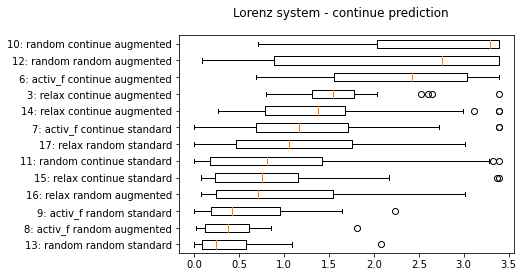

In [9]:
boxplots(results_split['lorenz'], 'continue')
plt.suptitle('Lorenz system - continue prediction')
plt.show()

In [4]:
results[7]['opt_parameters']

{'sigma': 0.01,
 'gamma': 25.0,
 'ridge_alpha': 1e-08,
 'spect_rad': 4.060882064610251,
 'mean_degree': 2.079117239034718}

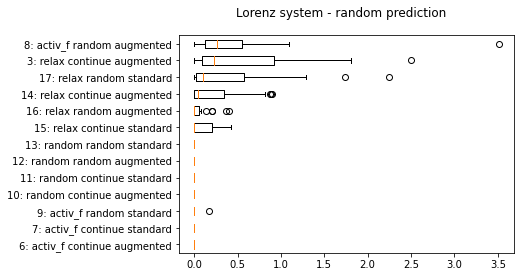

In [10]:
boxplots(results_split['lorenz'], 'random')
plt.suptitle('Lorenz system - random prediction')
plt.show()

In [4]:
results[8]['opt_parameters']

{'sigma': 2.518182559401357,
 'gamma': 5.790760655159745,
 'ridge_alpha': 0.0014066107907287084,
 'spect_rad': 19.64735209662313,
 'mean_degree': 5.0,
 'window': 0.6711954818252962,
 'overlap': 0.9}

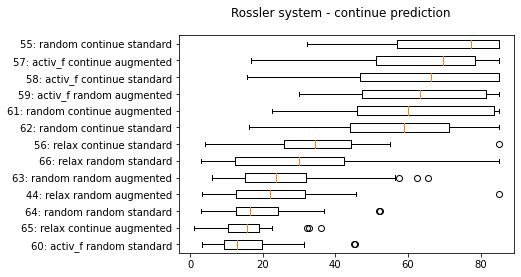

In [11]:
boxplots(results_split['rossler'], 'continue')
plt.suptitle('Rossler system - continue prediction')
plt.show()

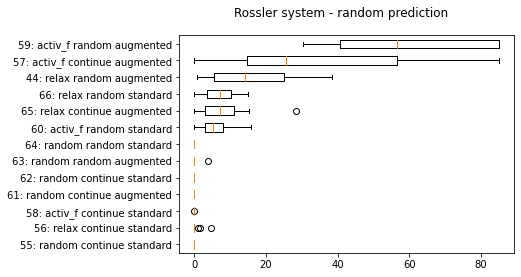

In [12]:
boxplots(results_split['rossler'], 'random')
plt.suptitle('Rossler system - random prediction')
plt.show()

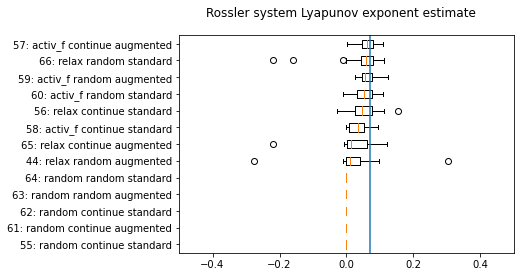

In [13]:
boxplots(results_split['rossler'], 'lyapunov',force_finite=True)
plt.suptitle('Rossler system Lyapunov exponent estimate')
plt.xlim(-0.5,0.5)
#Show the "true" value
#Based on https://arxiv.org/ftp/arxiv/papers/1412/1412.2242.pdf
plt.axvline(0.07062)
plt.show()

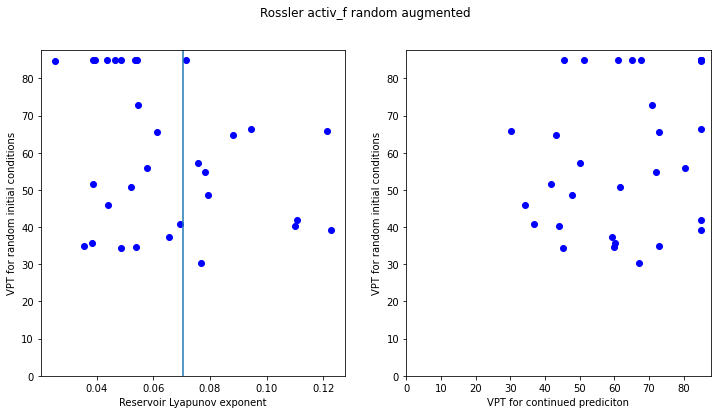

In [14]:
rossler_best = results[59]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(rossler_best['lyapunov'], rossler_best['random'], c='b')
plt.xlabel("Reservoir Lyapunov exponent")
plt.ylabel("VPT for random initial conditions")
plt.axvline(0.07062)
plt.ylim(0,None)

plt.subplot(1,2,2)
plt.scatter(rossler_best['continue'], rossler_best['random'], c='b')
plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.axis([0,None,0,None])

plt.suptitle("Rossler activ_f random augmented")
plt.show()

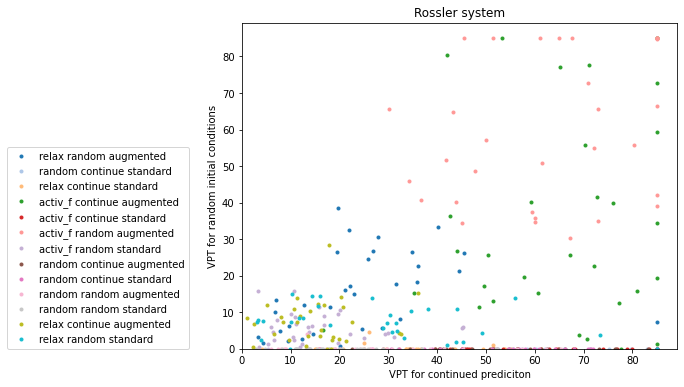

In [15]:
colors = plt.get_cmap('tab20')(np.linspace(0,1,len(results_split['rossler'])+1)[:-1])
plt.figure(figsize=(11,6))

for item, color in zip(results_split['rossler'],colors):
    plt.plot(item['continue'], item['random'], '.', color=color, label=' '.join(item['experiment'][1:]))

plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.title("Rossler system")
plt.axis([0,None,0,None])
lspace = 0.35
plt.subplots_adjust(left=lspace)
plt.legend(loc=(-lspace/(1-lspace),0))
plt.show()

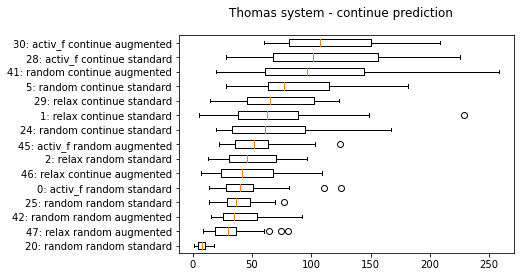

In [16]:
boxplots(results_split['thomas'], 'continue')
plt.suptitle('Thomas system - continue prediction')
plt.show()

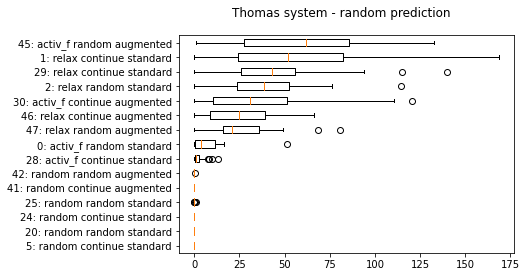

In [17]:
boxplots(results_split['thomas'], 'random')
plt.suptitle('Thomas system - random prediction')
plt.show()

In [3]:
print(results[28]['opt_parameters'])

{'sigma': 1.7525111278855319, 'gamma': 1.7228495809159075, 'ridge_alpha': 4.0176660163820185e-05, 'spect_rad': 2.9385095552190155, 'mean_degree': 3.442370236646486}


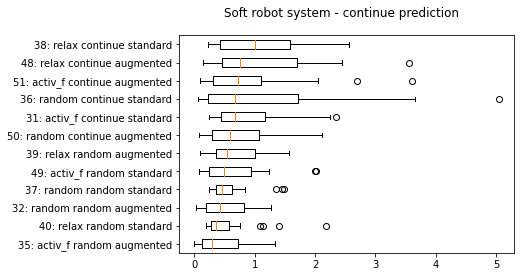

In [18]:
boxplots(results_split['softrobot'], 'continue')
plt.suptitle('Soft robot system - continue prediction')
plt.show()

In [3]:
for ids in [38,48,51,36,31]:
    data=results[ids]['continue']
    print(ids, np.mean(data), np.std(data)/np.sqrt(len(data)))

38 1.0624076241347438 0.14159907263845434
48 1.0746952123139524 0.1479360560478719
51 0.8734437680772071 0.13692492461430647
36 1.1756084364955326 0.2512852798693383
31 0.8872063668414717 0.11695761082185326


In [31]:
print(results[51]['opt_parameters'])
print(results[35]['opt_parameters'])

{'sigma': 0.6736122617008172, 'gamma': 18.772976319840613, 'ridge_alpha': 0.21859762078674633, 'spect_rad': 1.1638357483638153, 'mean_degree': 2.4119449028157924, 'window': 4.174365541574115, 'overlap': 0.3, 'delta': 0.39215464897158864}
{'sigma': 5.0, 'gamma': 0.1, 'ridge_alpha': 2.0, 'spect_rad': 25.0, 'mean_degree': 0.1, 'window': 0.1, 'overlap': 0.0, 'delta': 0.01}


In [5]:
print(results[36]['opt_parameters'])

{'sigma': 0.5645314642668725, 'gamma': 18.803702703218782, 'ridge_alpha': 2.0, 'spect_rad': 0.1, 'mean_degree': 2.5093658627762454, 'delta': 0.5987635152501467}


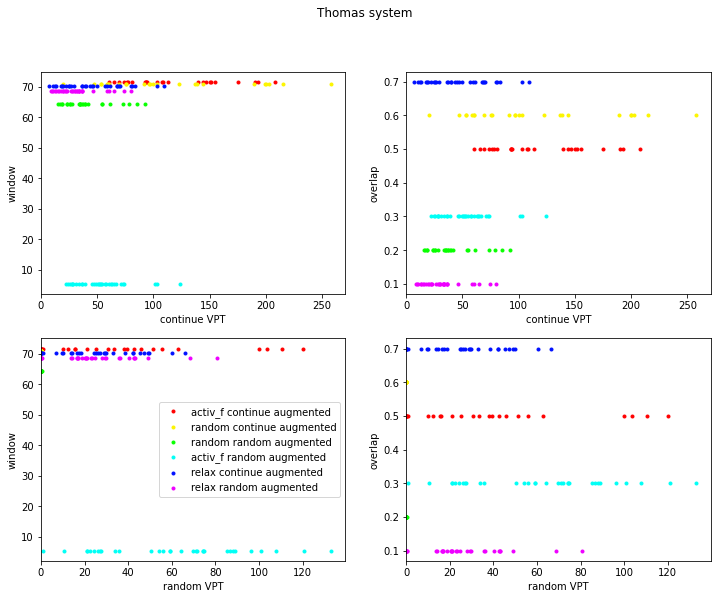

In [19]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['thomas'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Thomas system")
plt.show()

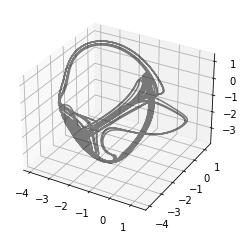

In [20]:
t,U=rc.orbit('thomas',duration=700,dt=0.1,trim=True)
rc.plot3d(U,'k');

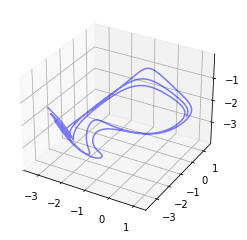

In [21]:
t,U=rc.orbit('thomas',duration=70,dt=0.1,trim=True)
rc.plot3d(U,'b');

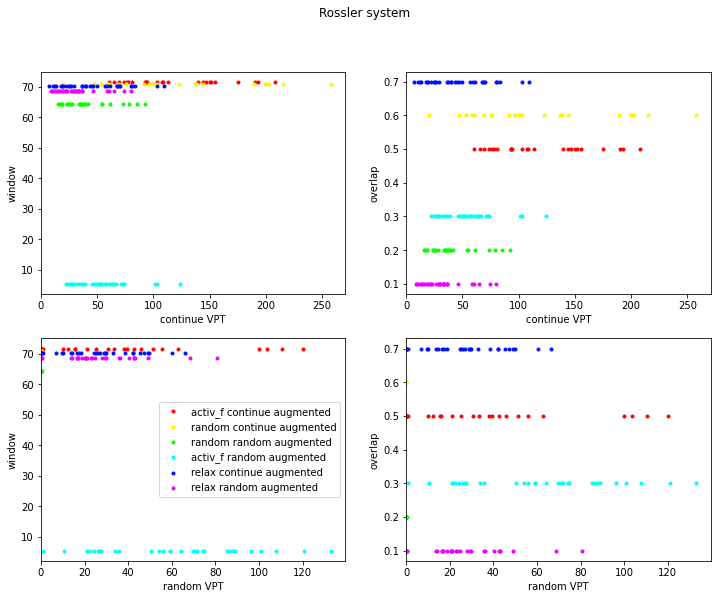

In [22]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['thomas'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Rossler system")
plt.show()

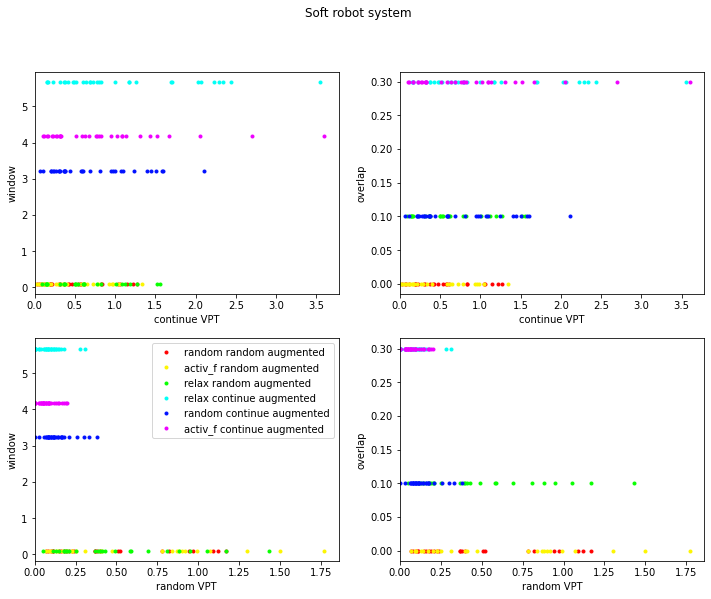

In [23]:
plt.figure(figsize=(12,9))
aug_results = [item for item in results_split['softrobot'] if item['experiment'][3]=='augmented']
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(aug_results)+1)[:-1])

which_exp = ['continue', 'random']
which_param = ['window','overlap']

for plt_num, (exp, param) in enumerate(product(which_exp, which_param)):
    plt.subplot(2,2,plt_num+1)
    for item, color in zip(aug_results,colors):
        l = len(item[exp])
        plt.plot(item[exp], [item['opt_parameters'][param]]*l, '.', color=color, label=' '.join(item['experiment'][1:]))
    plt.xlabel(f"{exp} VPT")
    plt.ylabel(param)
    plt.axis([0,None,None,None])
    if plt_num == 2:
        plt.legend()
    
plt.suptitle("Soft robot system")
plt.show()

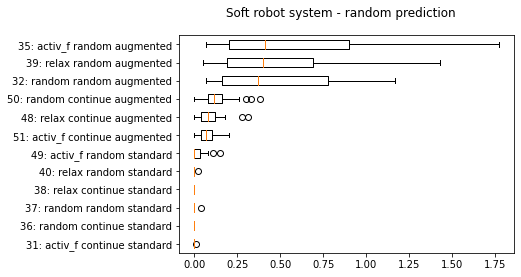

In [24]:
boxplots(results_split['softrobot'], 'random')
plt.suptitle('Soft robot system - random prediction')
plt.show()

In [4]:
from rescomp import optimizer as rcopt

In [15]:
softrobot = rcopt.get_system('softrobot')
softrobot.test_time = 30

optimizer = rcopt.ResCompOptimizer(softrobot,'relax','continue','augmented')
orbit = optimizer.generate_orbits(1,results[48]['opt_parameters'])[0]

In [16]:
tr, (Utr, Dtr), (ts, Dts), Uts, pre = orbit

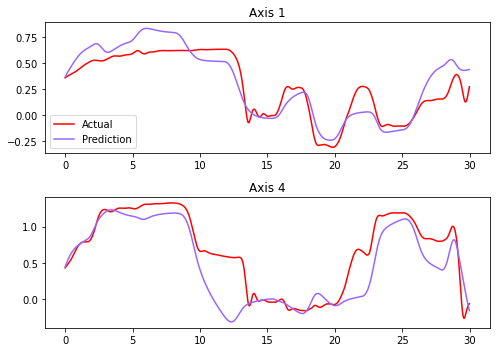

In [34]:
ac_colors = plt.get_cmap('autumn')(np.linspace(0,1,6))
pred_colors = plt.get_cmap('cool')(np.linspace(0,0.6,6))[::-1,:]

tsmin = np.min(ts)
ts = ts-tsmin
plt.figure(figsize=(7,5))
"""
plt.subplot(2,1,2)
for row, c in zip(Uts.T, ac_colors):
    plt.plot(ts, row, color=c)
    
for row, c in zip(pre.T, pred_colors):
    plt.plot(ts, row, color=c)
    """
    
plt.subplot(2,1,1)
n0=0
n=n0
plt.title(f"Axis {n+1}")
plt.plot(ts, Uts[:,n], color=ac_colors[n0],label='Actual')
plt.plot(ts, pre[:,n], color=pred_colors[n0],label='Prediction')
plt.legend()

plt.subplot(2,1,2)
n=3
plt.title(f"Axis {n+1}")
plt.plot(ts, Uts[:,n], color=ac_colors[n0])
plt.plot(ts, pre[:,n], color=pred_colors[n0])

plt.tight_layout()
plt.show()

In [23]:
print(rcopt.get_vptime(softrobot, (ts,None), Uts, pre))

0.4900035164025667


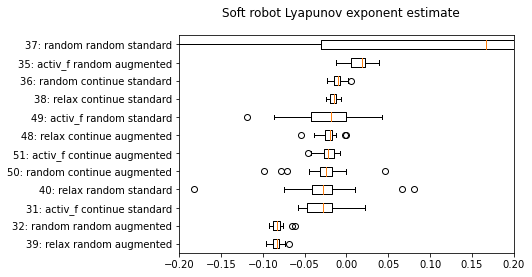

In [25]:
boxplots(results_split['softrobot'], 'lyapunov')
plt.suptitle('Soft robot Lyapunov exponent estimate')
plt.xlim(-0.2,0.2)
plt.show()

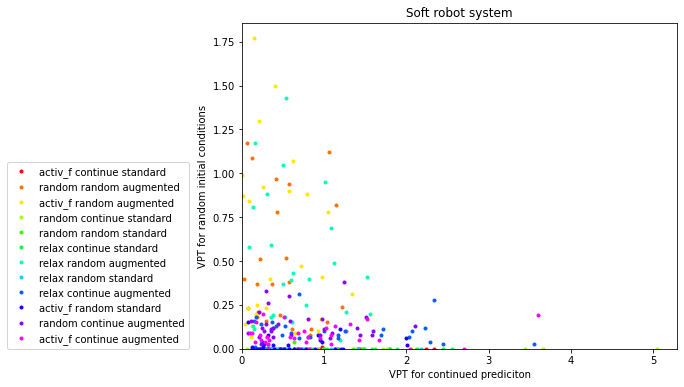

In [26]:
colors = plt.get_cmap('hsv')(np.linspace(0,1,len(results_split['rossler'])+1)[:-1])
plt.figure(figsize=(11,6))

for item, color in zip(results_split['softrobot'],colors):
    plt.plot(item['continue'], item['random'], '.', color=color, label=' '.join(item['experiment'][1:]))

plt.xlabel("VPT for continued prediciton")
plt.ylabel("VPT for random initial conditions")
plt.title("Soft robot system")
plt.axis([0,None,0,None])
lspace = 0.35
plt.subplots_adjust(left=lspace)
plt.legend(loc=(-lspace/(1-lspace),0))
plt.show()